In [94]:

import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Load data
nba_df= pd.read_excel(r"D:\DKATUBES\2023-2024 NBA Player Stats - Playoffs.xlsx")

nba_df[["Player","GP", "3P", "3PA", "3P%", "eFG%", "Label"]].head()


,Player,GP,3P,3PA,3P%,eFG%,Label
0,Damian Lillard,4,5.0,12.0,0.417,0.543,1
1,Luka Doncic,22,3.1,9.6,0.322,0.514,1
2,Tyrese Haliburton,15,3.5,9.3,0.379,0.612,1
3,Tyrese Maxey,6,3.7,9.2,0.400,0.558,1
4,D'Angelo Russell,5,2.8,8.8,0.318,0.479,1


C:\Users\Pongo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


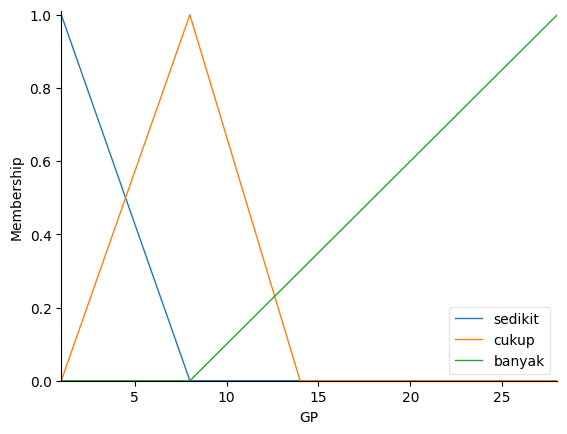

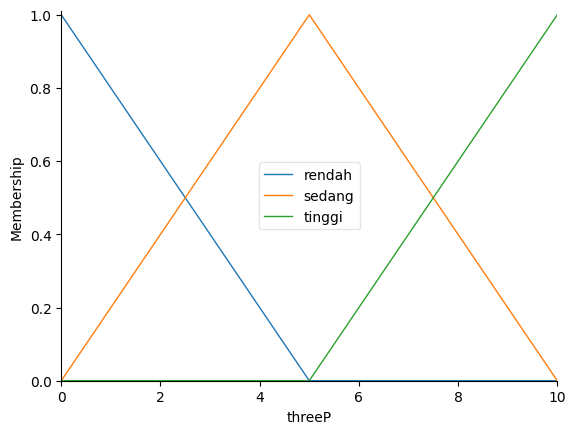

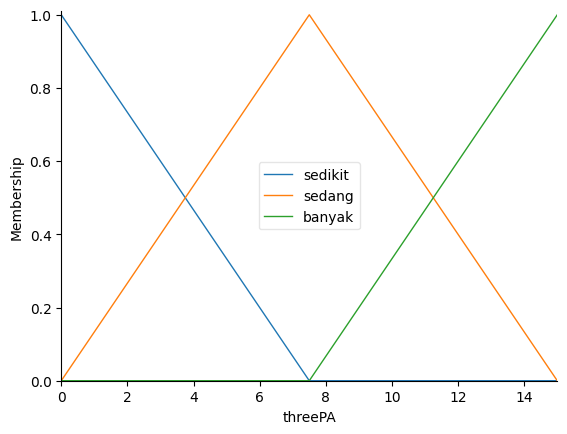

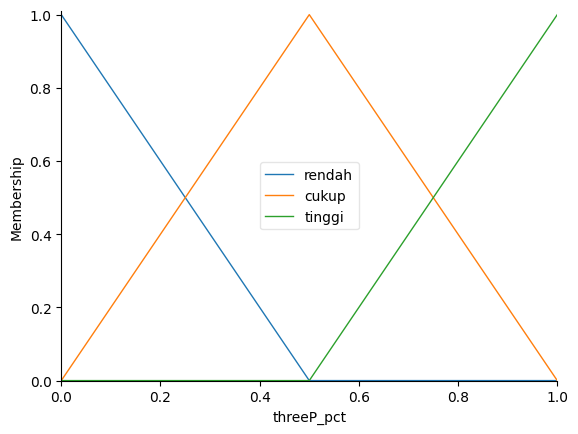

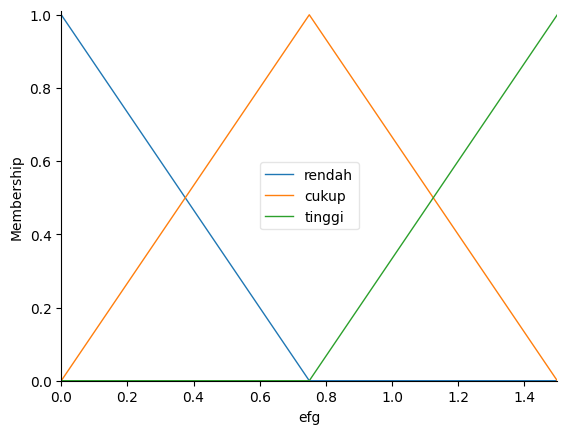

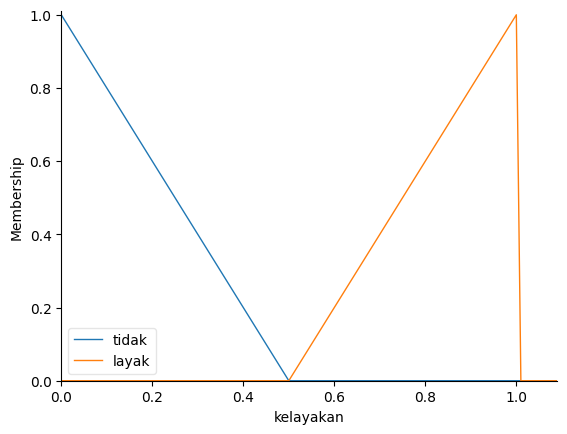

In [95]:
GP = ctrl.Antecedent(np.arange(1, 29, 1), 'GP')
threeP = ctrl.Antecedent(np.arange(0.0, 10.1, 0.1), 'threeP')
threePA = ctrl.Antecedent(np.arange(0.0, 15.1, 0.1), 'threePA')
threeP_pct = ctrl.Antecedent(np.arange(0.0, 1.01, 0.01), 'threeP_pct')
efg = ctrl.Antecedent(np.arange(0.00, 1.51, 0.01), 'efg')
kelayakan = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'kelayakan')

GP['sedikit'] = fuzz.trimf(GP.universe, [1, 1, 8])
GP['cukup'] = fuzz.trimf(GP.universe, [1, 8, 14])
GP['banyak'] = fuzz.trimf(GP.universe, [8, 28, 28])
GP.view()

threeP['rendah'] = fuzz.trimf(threeP.universe, [0.0, 0.0, 5.0])
threeP['sedang'] = fuzz.trimf(threeP.universe, [0.0, 5.0, 10.0])
threeP['tinggi'] = fuzz.trimf(threeP.universe, [5.0, 10.0, 10.0])
threeP.view()

threePA['sedikit'] = fuzz.trimf(threePA.universe, [0.0, 0.0, 7.5])
threePA['sedang'] = fuzz.trimf(threePA.universe, [0.0, 7.5, 15.0])
threePA['banyak'] = fuzz.trimf(threePA.universe, [7.5, 15.0, 15.0])
threePA.view()

threeP_pct['rendah'] = fuzz.trimf(threeP_pct.universe, [0.0, 0.0, 0.5])
threeP_pct['cukup'] = fuzz.trimf(threeP_pct.universe, [0.0, 0.5, 1.0])
threeP_pct['tinggi'] = fuzz.trimf(threeP_pct.universe, [0.5, 1.0, 1.0])
threeP_pct.view()

efg['rendah'] = fuzz.trimf(efg.universe, [0.0, 0.0, 0.75])
efg['cukup'] = fuzz.trimf(efg.universe, [0.0, 0.75, 1.5])
efg['tinggi'] = fuzz.trimf(efg.universe, [0.75, 1.5, 1.5])
efg.view()

kelayakan['tidak'] = fuzz.trimf(kelayakan.universe, [0.0, 0.0, 0.5])
kelayakan['layak']  = fuzz.trimf(kelayakan.universe, [0.5, 1.0, 1.0])
kelayakan.view()


In [ ]:

rules = [
    ctrl.Rule(threeP['rendah'], kelayakan['tidak']),
    ctrl.Rule(threeP['sedang'] & GP['sedikit'], kelayakan['tidak']),
    ctrl.Rule(threeP['sedang'] & GP['banyak'], kelayakan['layak']),
    ctrl.Rule(threeP['tinggi'] & GP['sedikit'] & threeP['rendah'] & threePA['sedikit'], kelayakan['tidak']),
    ctrl.Rule(threeP['tinggi'] & GP['sedikit'] & threeP['rendah'] & threePA['sedang'], kelayakan['layak']),
    ctrl.Rule(threeP['tinggi'] & GP['sedikit'] & threeP['rendah'] & threePA['banyak'], kelayakan['tidak']),
    ctrl.Rule(threeP['tinggi'] & GP['sedikit'] & threeP['tinggi'], kelayakan['layak']),
    ctrl.Rule(threeP['tinggi'] & GP['banyak'] & efg['rendah'], kelayakan['tidak']),
    ctrl.Rule(threeP['tinggi'] & GP['banyak'] & efg['cukup'] & GP['sedikit'], kelayakan['tidak']),
    ctrl.Rule(threeP['tinggi'] & GP['banyak'] & efg['cukup'] & GP['banyak'] & threeP_pct['rendah'], kelayakan['tidak']),
    ctrl.Rule(threeP['tinggi'] & GP['banyak'] & efg['cukup'] & GP['banyak'] & threeP_pct['cukup'], kelayakan['layak']),
    ctrl.Rule(threeP['tinggi'] & GP['banyak'] & efg['tinggi'], kelayakan['layak'])
]

kelayakan_ctrl = ctrl.ControlSystem(rules)

In [97]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = []
for _, row in nba_df.iterrows():
    kelayakan_simulator = ctrl.ControlSystemSimulation(kelayakan_ctrl)
    try:
        kelayakan_simulator.input['threeP_pct'] = row['3P%']
        kelayakan_simulator.input['threePA'] = row['3PA']
        kelayakan_simulator.input['threeP'] = row['3P']
        kelayakan_simulator.input['efg'] = row['eFG%']
        kelayakan_simulator.input['GP'] = row['GP']
        kelayakan_simulator.compute()
        score = kelayakan_simulator.output['kelayakan']
        pred = 1 if score >= 0.5 else 0
    except Exception as e:
        pred = 0  # fallback if error
    predictions.append(pred)

nba_df['Fuzzy_Pred'] = predictions

# Evaluasi akurasi
acc = accuracy_score(nba_df["Label"], nba_df["Fuzzy_Pred"])
prec = precision_score(nba_df["Label"], nba_df["Fuzzy_Pred"])
recall = recall_score(nba_df["Label"], nba_df["Fuzzy_Pred"])
f1 = f1_score(nba_df["Label"], nba_df["Fuzzy_Pred"])
print(classification_report(nba_df["Label"], nba_df["Fuzzy_Pred"]))
print("Akurasi Fuzzy Mamdani:", round(acc * 100, 2), "%")
print("Presisi Fuzzy Mamdani:", round(prec * 100, 2), "%")
print("Recall Score Fuzzy Mamdani:", round(recall * 100, 2), "%")
print("F1 Score Fuzzy Mamdani:", round(f1 * 100, 2), "%")

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       135
           1       1.00      0.04      0.07        79

    accuracy                           0.64       214
   macro avg       0.82      0.52      0.43       214
weighted avg       0.77      0.64      0.52       214

Akurasi Fuzzy Mamdani: 64.49 %
Presisi Fuzzy Mamdani: 100.0 %
Recall Score Fuzzy Mamdani: 3.8 %
F1 Score Fuzzy Mamdani: 7.32 %


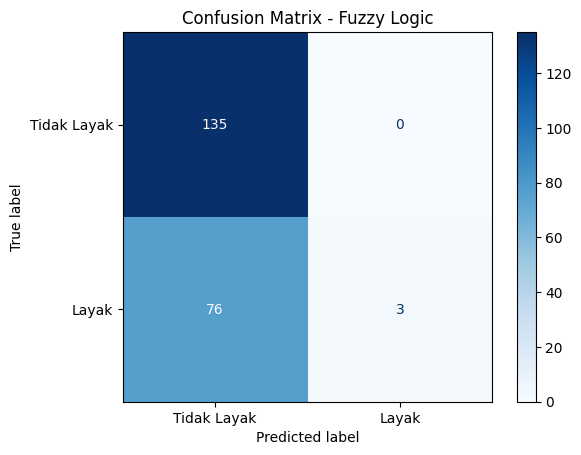

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ambil label aktual dan prediksi fuzzy
y_true = nba_df['Label']
y_pred = nba_df['Fuzzy_Pred']

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Tampilkan dengan visualisasi
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Layak', 'Layak'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Fuzzy Logic")
plt.show()